**Import Libraries**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

**Set up pipeline to undistort single image**

In [2]:
#read all distorted image files from ./camera_cal
path = "./camera_cal"
files = []
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))
            
imgs = []
for file in files:
    img = mpimg.imread(file)
    imgs.append(img)

#set up chess board size
nx = 9
ny = 6
# set up assumed objective chess board corner points and detected corners points
objpoints = []
imgpoints = []

#objects points are 3D coordinates (x ,y ,z) with z is always 0 because chess board is flat
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
#detect and set up chess board corners points
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)


#function to output undistorted picture, 
def undistort(img, objpoints, imgpoints):
    """
    Input: img - original image import from matplot
           objpoints, imgpoints - assumed chess board cormers point coordinates and detected corners points
    Output: undistorted image
    """
    # calibrate camera and get distortion coefficients and camera transform matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

**Testing undistort function**

./calibration_output/calibration2_output.jpg


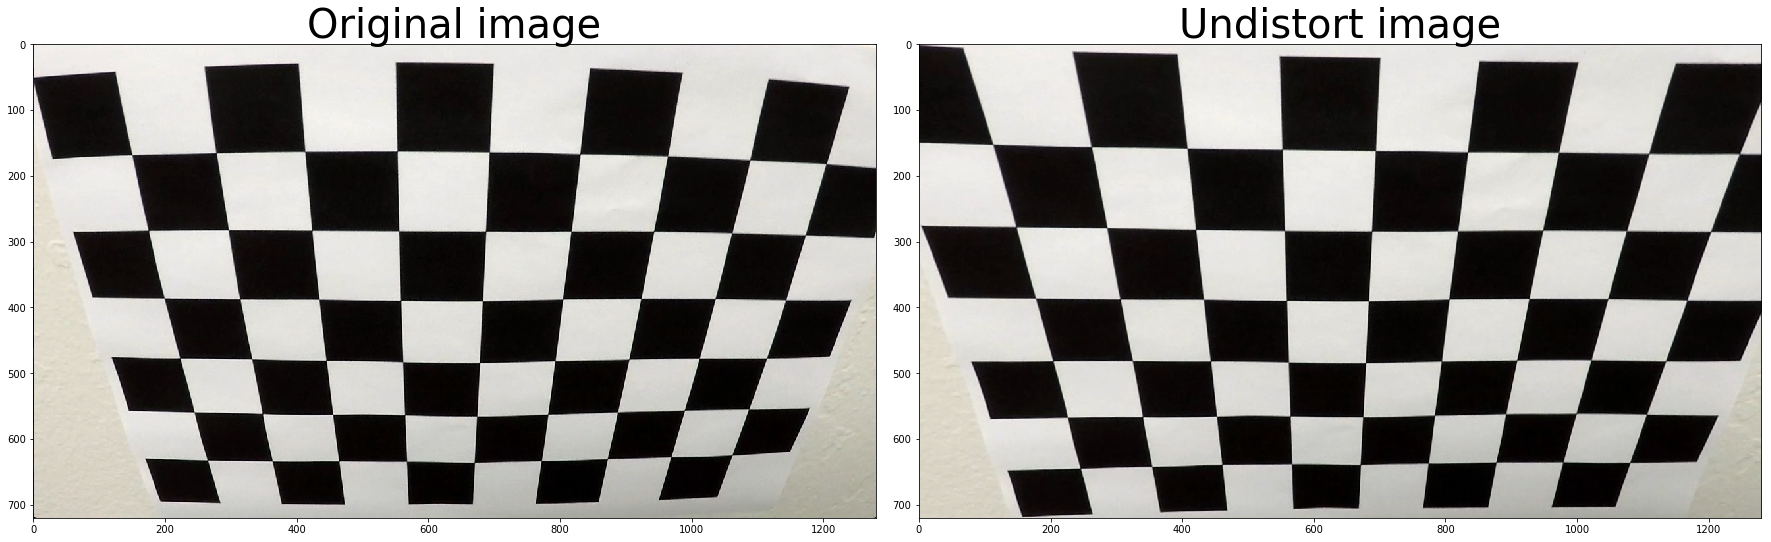

In [3]:
# choose a image calibration 
file = files[13]
img = mpimg.imread(file)
#testing and output file to ./caliberation_output
undist = undistort(img, objpoints, imgpoints)
print("./calibration_output/"+file[13:len(file)-4]+"_output.jpg")
cv2.imwrite("./calibration_output/"+file[13:len(file)-4]+"_output.jpg",cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistort image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Create a threshold binary image**

In [4]:
#set up sobel magnitude threshhold. 
thresh_min = 20
thresh_max = 100

#set up saturation channel threshold
s_thresh_min = 170
s_thresh_max = 255

#function to apply gradient threshold on magnitude
def gradient_threshold(img, magx = 1, kernel = 3):
    """
    Intput:
            img - an undistorted image produced by def undistort(img, objpoints, imgpoints)
            magx - the portion of x gradient in magnitude computation, ranging from 0 ~ 1.0 .
                    the default is 1.0 because usually x gradient is more important as lane lines are often vertical
            kernel - the kernel when applyting sobel operation
    
    Output: a binary image indicate gradient threshold
    
    """
    
        # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude with weight on x, y axis
    gradmag = np.sqrt((sobelx*magx)**2 + (sobely*(1- magx))**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    grad_output = np.zeros_like(gradmag)
    grad_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    
    # Return the binary image
    return grad_output
    
#function to apply color(saturation) threshold
def satur_threshold(img):
    """
    Input:
            img - an undistorted image produced by def undistort(img, objpoints, imgpoints)
    
    Output:
            a binary image met saturation threshold
    """
    #convert to HLS channel and get saturation value for every pixel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    satur_output = np.zeros_like(s_channel)
    satur_output[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1 
    
    return satur_output

#function to fuse the thresholds
def fusion_thresholds(thresh_outputs):
    """
    Input:
            thresh_outputs - images produces by threshold methods
            
    Output: binary image that met one of the thresholds
    """
    fused_output = np.zeros_like(thresh_outputs[0])
    fused_output[np.any([img == 1 for img in thresh_outputs], axis = 0)] = 1
    
    return fused_output

**Create an undistort car camera image**

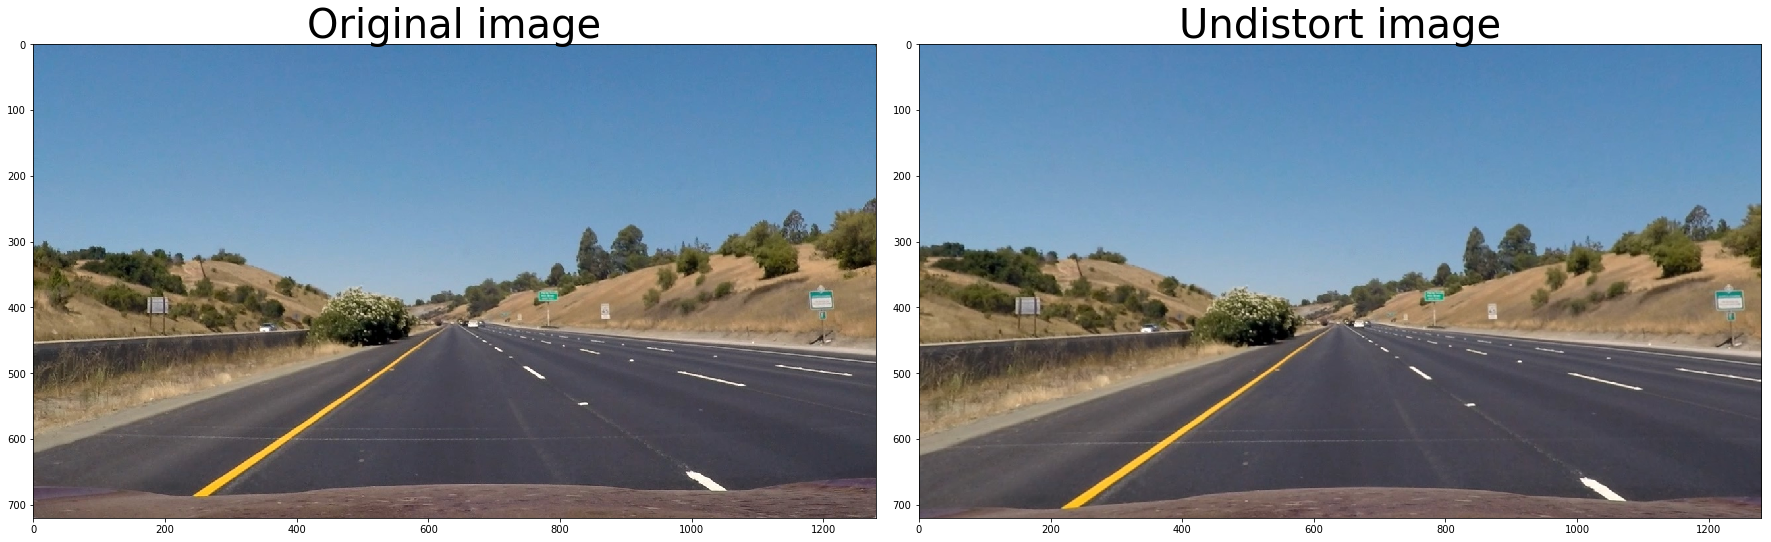

In [5]:
car_image_path = "./test_images/straight_lines1.jpg"
img = mpimg.imread(car_image_path)

undist = undistort(img, objpoints, imgpoints)

cv2.imwrite("./output_images/car_undistort.jpg",cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistort image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**set up region of interest**

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

**show region of interest**

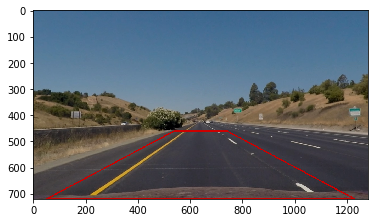

In [14]:
car_image_path = "./test_images/straight_lines1.jpg"
car_img = mpimg.imread(car_image_path)

car_img = undistort(car_img, objpoints, imgpoints)
height = car_img.shape[0]
width = car_img.shape[1]
car_vertices = np.array([[(50,height),(width/2-100, height/2 + 100), (width/2+100, height/2 + 100), \
                          (width-50,height)]], dtype=np.int32)

mask = np.zeros_like(car_img)
cv2.polylines(car_img, car_vertices, True, (255, 0, 0), 3)

drawn_region = cv2.addWeighted(car_img, 0.8, mask, 1.0, 0)

plt.imshow(drawn_region)

**Function to apply all thresholds and region of interest **

In [15]:
def threshold_process(img):
    """
    This function is the highest port to apply thresholds.
    Input: Original Image
    
    Output: Binary Image with lane line pixels are shown in the region of interest
    """
    #get threshold images
    grad_output = gradient_threshold(img)
    satur_output = satur_threshold(img)
    
    fused_output = fusion_thresholds([grad_output, satur_output])
    
    #set region of interest
    height = fused_output.shape[0]
    width = fused_output.shape[1]
    mask_vertices = np.array([[(50,height),(width/2-100, height/2 + 100), (width/2+100, height/2 + 100), \
                          (width-50,height)]], dtype=np.int32)
    #apply mask
    result = region_of_interest(fused_output, mask_vertices)
    
    return result

**testing threshold and mask** 

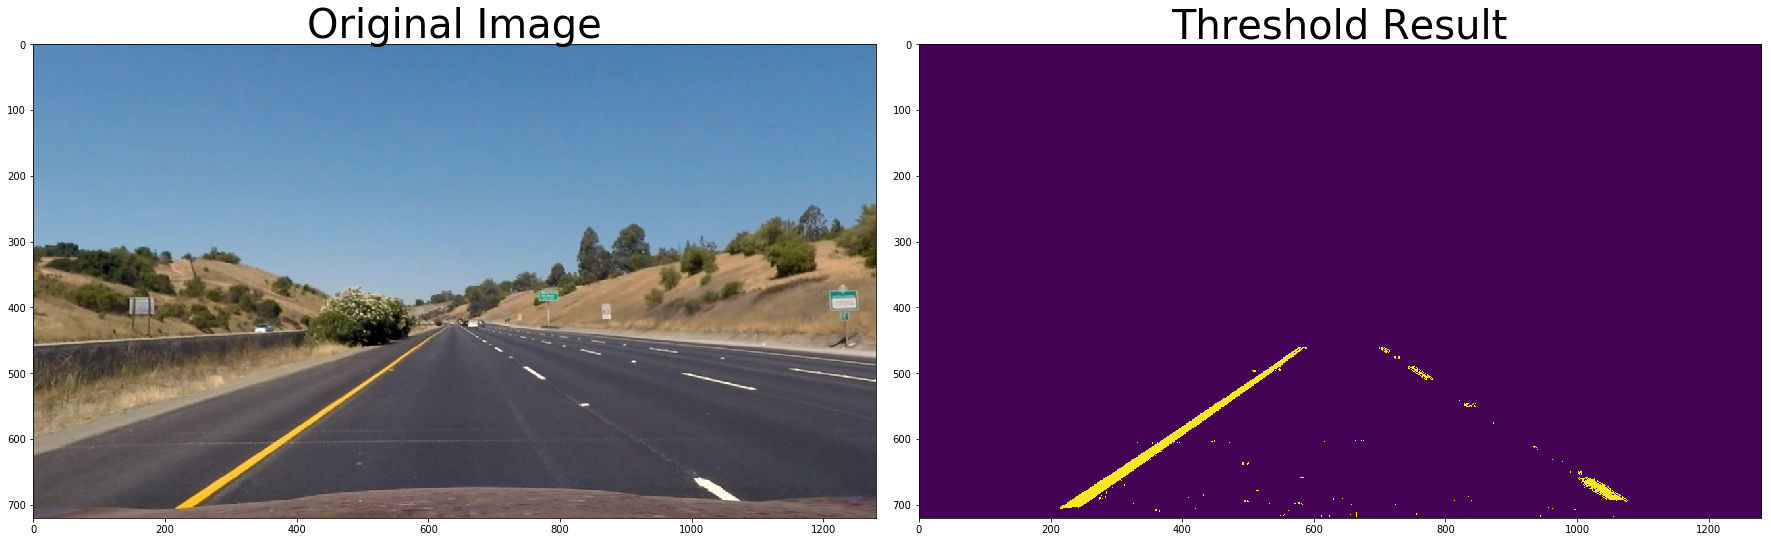

In [16]:
car_image_path = "./test_images/straight_lines1.jpg"
car_img = mpimg.imread(car_image_path)

car_img = undistort(car_img, objpoints, imgpoints)

threshold_image = threshold_process(car_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(car_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshold_image)
ax2.set_title('Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)